<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

#  입자 밀도 조절


1. Splitting: 크기가 너무 커졌을 때 쪼개기
1. Cloning: 기울기(gradient)가 너무 클때 추가
1. Pruning: 투명해졌을 때 삭제

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video
from matplotlib.patches import Ellipse, Rectangle

# Keep figures sharp
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120

# Image size (normalized coordinate frame [-1, 1])
H, W = 96, 96

def make_pixel_grid(H, W, device="cpu"):
    xs = (torch.arange(W, device=device) + 0.5) / W * 2 - 1
    ys = (torch.arange(H, device=device) + 0.5) / H * 2 - 1
    Y, X = torch.meshgrid(ys, xs, indexing="ij")
    Y = torch.flip(Y, dims=[0])
    return torch.stack([X, Y], dim=-1)

def render_gaussians_2d(H, W, mus, sigmas, thetas, opacities, rgbs, n_sigma=3.0):
    P = make_pixel_grid(H, W, device=mus.device)
    img = torch.zeros((H, W, 3), device=mus.device, dtype=mus.dtype)

    for i in range(len(mus)):
        mu = mus[i]
        sigma = torch.clamp(sigmas[i], min=1e-3)
        theta = thetas[i]
        opacity = opacities[i]
        rgb = rgbs[i]

        # Axis-aligned 3σ (default) box for the rotated ellipse to cull distant pixels
        cos_t, sin_t = torch.cos(theta), torch.sin(theta)
        half_w = n_sigma * (torch.abs(cos_t) * sigma[0] + torch.abs(sin_t) * sigma[1])
        half_h = n_sigma * (torch.abs(sin_t) * sigma[0] + torch.abs(cos_t) * sigma[1])
        x0, x1 = mu[0] - half_w, mu[0] + half_w
        y0, y1 = mu[1] - half_h, mu[1] + half_h
        mask_bbox = (P[..., 0] >= x0) & (P[..., 0] <= x1) & (P[..., 1] >= y0) & (P[..., 1] <= y1)
        if not mask_bbox.any():
            continue

        # Gaussian evaluation only inside the bounding box
        R = torch.stack([torch.stack([cos_t, -sin_t]), torch.stack([sin_t, cos_t])])
        sigma_inv = R @ torch.diag(1.0 / (sigma ** 2)) @ R.T

        diff = P[mask_bbox] - mu
        exponent = torch.einsum("bi,ij,bj->b", diff, sigma_inv, diff)
        f_x = torch.exp(-0.5 * exponent)
        img[mask_bbox] = img[mask_bbox] + (opacity * rgb).view(1, 3) * f_x.unsqueeze(-1)

    return torch.clamp(img, 0.0, 1.0)

def draw_gaussian_ellipses(ax, mus, sigmas, thetas, color="yellow", label=None, alpha=0.7, n_sigma=3.0):
    """Draw n-sigma ellipses for 2D Gaussians in normalized coords [-1, 1]."""
    mus = mus.detach().cpu()
    sigmas = sigmas.detach().cpu()
    thetas = thetas.detach().cpu()
    first = True
    for i in range(len(mus)):
        width = sigmas[i, 0].item() * n_sigma * 2.0
        height = sigmas[i, 1].item() * n_sigma * 2.0
        angle = float(thetas[i].item() * 180.0 / np.pi)
        e = Ellipse(
            (mus[i, 0].item(), mus[i, 1].item()),
            width=width,
            height=height,
            angle=angle,
            edgecolor=color,
            facecolor="none",
            linewidth=2.0,
            alpha=alpha,
            label=label if first and label is not None else None,
        )
        ax.add_patch(e)
        first = False

    ax.scatter(mus[:, 0], mus[:, 1], c=color, s=30, marker="x", linewidths=2, alpha=alpha)

def show_images(images, titles, figsize=None, vmin=0.0, vmax=1.0):
    n = len(images)
    figsize = figsize or (3.6 * n, 3.6)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    axes = [axes] if n == 1 else axes
    for ax, im, title in zip(axes, images, titles):
        if torch.is_tensor(im):
            im = im.detach().cpu().numpy()
        ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def show_image_grid(images, titles, cols=4, cell_size=3.2, vmin=0.0, vmax=1.0):
    n = len(images)
    cols = int(max(1, cols))
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i < n:
            im = images[i]
            if torch.is_tensor(im):
                im = im.detach().cpu().numpy()
            ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def diff_image(a, b):
    d = torch.abs(a - b)
    mag = torch.clamp(torch.norm(d, dim=-1, keepdim=True) / np.sqrt(3.0), 0.0, 1.0)
    return d, mag.repeat(1, 1, 3)

def save_training_video(frames, filename, fps=30, title="Training Progress"):
    if len(frames) == 0:
        print(f"No frames to save for {filename}")
        return

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis("off")

    im_display = ax.imshow(frames[0], vmin=0.0, vmax=1.0, interpolation="nearest")
    text = ax.text(0.5, -0.05, "Iteration: 0", transform=ax.transAxes, ha="center", fontsize=12)

    def update(frame_idx):
        im_display.set_array(frames[frame_idx])
        text.set_text(f"Iteration: {frame_idx}")
        return [im_display, text]

    anim = FuncAnimation(fig, update, frames=len(frames), interval=1000 / fps, blit=True)
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Video saved to {filename}")

## 1. Splitting oversized Gaussians


When a Gaussian grows beyond a size threshold, split it into two smaller Gaussians along its major axis and divide opacity.

Splitting: 1 Gaussians → 1 new points added
Gaussians before: 1, after split: 2


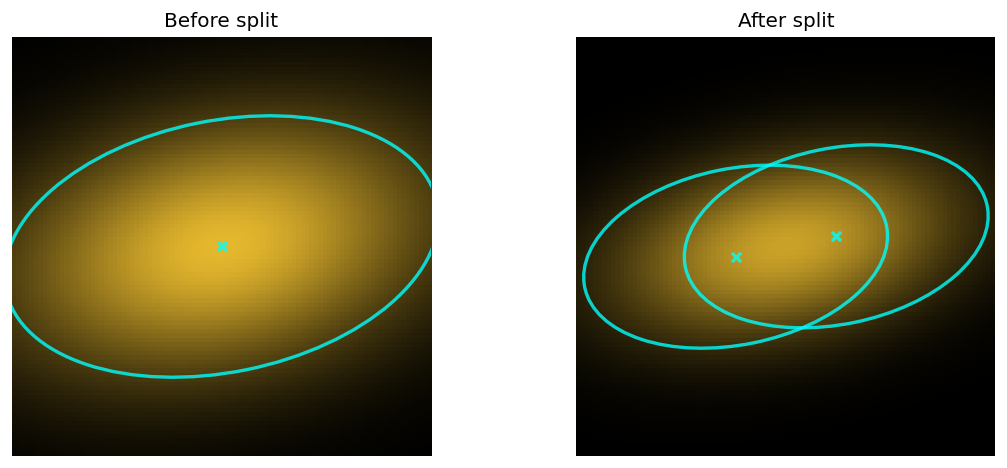

In [ ]:
def split_gaussians_if_large(mus, sigmas, thetas, opacities, rgbs, max_sigma=0.35):
    """Split Gaussians whose largest sigma exceeds max_sigma along their major axis."""
    largest = sigmas.max(dim=1).values
    large_mask = TODO
    if not torch.any(large_mask):
        return mus, sigmas, thetas, opacities, rgbs
    
    # Clone originals to serve as the "updated parents" (Child 1)
    # This preserves index alignment: index i corresponds to optimizer param i
    new_mus = mus.clone()
    new_sigmas = sigmas.clone()
    new_thetas = thetas.clone()
    new_opacities = opacities.clone()
    new_rgbs = rgbs.clone()
    
    # Collect new children (Child 2) to append at the end
    added_mus, added_sigmas, added_thetas, added_opacities, added_rgbs = [], [], [], [], []
    
    split_indices = torch.nonzero(large_mask).flatten()
    num_splits = len(split_indices)
    if num_splits > 0:
        print(f"Splitting: {num_splits} Gaussians → {num_splits} new points added")
    
    for i in split_indices:
        cos_t, sin_t = torch.cos(thetas[i]), torch.sin(thetas[i])
        R = torch.stack([torch.stack([cos_t, -sin_t]), torch.stack([sin_t, cos_t])])
        major_first = sigmas[i, 0] >= sigmas[i, 1]
        major_dir = R[:, 0] if major_first else R[:, 1]
        
        offset = major_dir * (largest[i] * 0.35)
        child_sigma = torch.clamp(sigmas[i] * 0.7, min=1e-3)
        child_opacity = opacities[i] * 0.5
        
        # Update original slot (Child 1)
        new_mus[i] = mus[i] + offset
        new_sigmas[i] = child_sigma
        new_opacities[i] = child_opacity
        
        # Create new particle (Child 2)
        added_mus.append(mus[i] - offset)
        added_sigmas.append(child_sigma)
        added_thetas.append(thetas[i])
        added_opacities.append(child_opacity)
        added_rgbs.append(rgbs[i])
        
    # Concatenate: [Updated Originals] + [New Children]
    return (
        torch.cat([new_mus, torch.stack(added_mus)], dim=0),
        torch.cat([new_sigmas, torch.stack(added_sigmas)], dim=0),
        torch.cat([new_thetas, torch.stack(added_thetas)], dim=0),
        torch.cat([new_opacities, torch.stack(added_opacities)], dim=0),
        torch.cat([new_rgbs, torch.stack(added_rgbs)], dim=0)
    )

# Demo: one oversized Gaussian gets split into two children
mus_demo = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
sigmas_demo = torch.tensor([[0.7, 0.4]], dtype=torch.float32)
thetas_demo = torch.tensor([0.2], dtype=torch.float32)
opacities_demo = torch.tensor([0.9], dtype=torch.float32)
rgbs_demo = torch.tensor([[1.0, 0.8, 0.2]], dtype=torch.float32)

img_before = render_gaussians_2d(H, W, mus_demo, sigmas_demo, thetas_demo, opacities_demo, rgbs_demo)
split_out = split_gaussians_if_large(mus_demo, sigmas_demo, thetas_demo, opacities_demo, rgbs_demo, max_sigma=0.35)
mus_split, sigmas_split, thetas_split, opacities_split, rgbs_split = split_out
img_after = render_gaussians_2d(H, W, mus_split, sigmas_split, thetas_split, opacities_split, rgbs_split)

print(f"Gaussians before: {len(mus_demo)}, after split: {len(mus_split)}")

# Draw Gaussian boundaries (n-sigma ellipses) on top of the images
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pairs = [
    (axes[0], img_before, "Before split", mus_demo, sigmas_demo, thetas_demo),
    (axes[1], img_after, "After split", mus_split, sigmas_split, thetas_split),
]
for ax, img, title, mus_v, sigmas_v, thetas_v in pairs:
    ax.imshow(img.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin="upper", vmin=0.0, vmax=1.0)
    draw_gaussian_ellipses(ax, mus_v, sigmas_v, thetas_v, color="cyan", alpha=0.8, n_sigma=1.5)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

## 2. Cloning High Gradient Point

When a Gaussian has a high positional gradient (indicating it's trying to move significantly to fit the data) but is not large enough to be split, we clone it. This creates a duplicate Gaussian at the same location, effectively increasing the density in that region.

**Why do they separate?**
Even though the clone is placed at the exact same location as the original, they will separate in subsequent iterations. This is because the original Gaussian has accumulated momentum in the optimizer (from previous steps), while the new clone is initialized with zero momentum. This difference in optimizer state causes them to take different steps immediately, allowing them to diverge and cover the high-error region effectively.

Cloning: 1 Gaussians → 1 new points added
Gaussians before: 1, after clone: 2


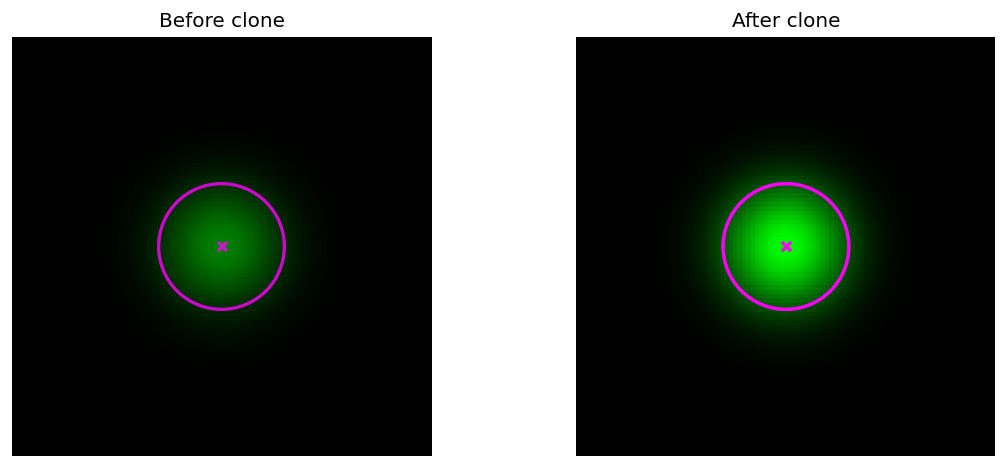

In [ ]:
def clone_gaussians_if_high_grad(mus, sigmas, thetas, opacities, rgbs, mus_grad, grad_threshold=0.1, max_sigma=None):
    """
    Clone Gaussians whose positional gradient norm exceeds grad_threshold.
    If max_sigma is provided, do NOT clone Gaussians larger than this size (they should be split instead).
    """
    if mus_grad is None:
        return mus, sigmas, thetas, opacities, rgbs

    # Compute gradient norms
    grad_norms = torch.norm(mus_grad, dim=-1)
    clone_mask = TODO
    
    # Exclude large Gaussians if requested (they should be split, not cloned)
    if max_sigma is not None:
        largest_sigma = sigmas.max(dim=1).values
        large_mask = largest_sigma > max_sigma
        clone_mask = clone_mask & (~large_mask)
    
    if not torch.any(clone_mask):
        return mus, sigmas, thetas, opacities, rgbs
    
    # Indices to clone
    clone_indices = torch.nonzero(clone_mask).flatten()
    num_clones = len(clone_indices)
    if num_clones > 0:
        print(f"Cloning: {num_clones} Gaussians → {num_clones} new points added")
    
    # Create clones (duplicates)
    added_mus = mus[clone_indices].clone()
    added_sigmas = sigmas[clone_indices].clone()
    added_thetas = thetas[clone_indices].clone()
    added_opacities = opacities[clone_indices].clone()
    added_rgbs = rgbs[clone_indices].clone()
    
    # Concatenate original + clones
    return (
        torch.cat([mus, added_mus], dim=0),
        torch.cat([sigmas, added_sigmas], dim=0),
        torch.cat([thetas, added_thetas], dim=0),
        torch.cat([opacities, added_opacities], dim=0),
        torch.cat([rgbs, added_rgbs], dim=0)
    )

# Demo: Clone a Gaussian with high gradient
mus_demo_c = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
sigmas_demo_c = torch.tensor([[0.2, 0.2]], dtype=torch.float32)
thetas_demo_c = torch.tensor([0.0], dtype=torch.float32)
opacities_demo_c = torch.tensor([0.5], dtype=torch.float32)
rgbs_demo_c = torch.tensor([[0.0, 1.0, 0.0]], dtype=torch.float32) # Green

# Simulate high gradient
mus_grad_demo = torch.tensor([[1.0, 1.0]], dtype=torch.float32)

img_before_c = render_gaussians_2d(H, W, mus_demo_c, sigmas_demo_c, thetas_demo_c, opacities_demo_c, rgbs_demo_c)

clone_out = clone_gaussians_if_high_grad(
    mus_demo_c, sigmas_demo_c, thetas_demo_c, opacities_demo_c, rgbs_demo_c, 
    mus_grad_demo, grad_threshold=0.5
)
mus_clone, sigmas_clone, thetas_clone, opacities_clone, rgbs_clone = clone_out

img_after_c = render_gaussians_2d(H, W, mus_clone, sigmas_clone, thetas_clone, opacities_clone, rgbs_clone)

print(f"Gaussians before: {len(mus_demo_c)}, after clone: {len(mus_clone)}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pairs = [
    (axes[0], img_before_c, "Before clone", mus_demo_c, sigmas_demo_c, thetas_demo_c),
    (axes[1], img_after_c, "After clone", mus_clone, sigmas_clone, thetas_clone),
]
for ax, img, title, mus_v, sigmas_v, thetas_v in pairs:
    ax.imshow(img.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin="upper", vmin=0.0, vmax=1.0)
    draw_gaussian_ellipses(ax, mus_v, sigmas_v, thetas_v, color="magenta", alpha=0.8, n_sigma=1.5)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# Adam-state extension helper (mimics 3DGS cat_tensors_to_optimizer behavior)
def _cat_param_and_state(opt, old_param, new_rows):
    if new_rows.numel() == 0:
        return old_param
    group = opt.param_groups[0]
    idx = None
    for i, p in enumerate(group["params"]):
        if p is old_param:
            idx = i
            break
    if idx is None:
        raise ValueError("Parameter not found in optimizer")
    device, dtype = old_param.device, old_param.dtype
    with torch.no_grad():
        combined = torch.cat([old_param.detach(), new_rows.to(device=device, dtype=dtype)], dim=0)
    new_param = torch.nn.Parameter(combined)
    group["params"][idx] = new_param
    state = opt.state.pop(old_param, {})
    step = state.get("step", 0)
    exp_avg = state.get("exp_avg", torch.zeros_like(old_param))
    exp_avg_sq = state.get("exp_avg_sq", torch.zeros_like(old_param))
    opt.state[new_param] = {
        "step": step,
        "exp_avg": torch.cat([exp_avg, torch.zeros_like(new_rows)], dim=0),
        "exp_avg_sq": torch.cat([exp_avg_sq, torch.zeros_like(new_rows)], dim=0),
    }
    return new_param

def extend_optimizer_with_new_points(opt, old_params, full_params, prev_count):
    mus_old, sigmas_old, thetas_old, opacities_old, rgbs_old = old_params
    mus_full, sigmas_full, thetas_full, opacities_full, rgbs_full = full_params
    
    # 1. Update the existing parameters in-place (Child 1 updates)
    # We must update .data so _cat_param_and_state sees the new values
    mus_old.data[:] = mus_full[:prev_count]
    sigmas_old.data[:] = sigmas_full[:prev_count]
    thetas_old.data[:] = thetas_full[:prev_count]
    opacities_old.data[:] = opacities_full[:prev_count]
    rgbs_old.data[:] = rgbs_full[:prev_count]

    # 2. Append the new rows (Child 2)
    mus_new_rows = mus_full[prev_count:]
    sigmas_new_rows = sigmas_full[prev_count:]
    thetas_new_rows = thetas_full[prev_count:]
    opacities_new_rows = opacities_full[prev_count:]
    rgbs_new_rows = rgbs_full[prev_count:]
    
    mus_param = _cat_param_and_state(opt, mus_old, mus_new_rows)
    sigmas_param = _cat_param_and_state(opt, sigmas_old, sigmas_new_rows)
    thetas_param = _cat_param_and_state(opt, thetas_old, thetas_new_rows)
    opacities_param = _cat_param_and_state(opt, opacities_old, opacities_new_rows)
    rgbs_param = _cat_param_and_state(opt, rgbs_old, rgbs_new_rows)
    return mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param

## 3. Pruning Transparent Gaussians

Remove Gaussians that have become nearly transparent (opacity below threshold) or excessively large. This prevents accumulation of useless Gaussians and keeps the representation efficient.

Pruning: 1 Gaussians removed (kept 2)
Gaussians before: 3, after pruning: 2
Removed opacities: [0.004999999888241291]


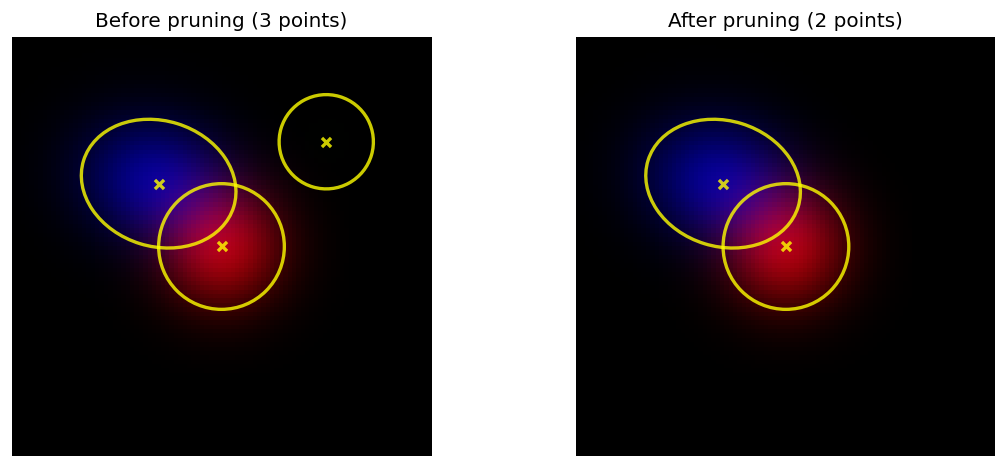

In [ ]:
def prune_gaussians(mus, sigmas, thetas, opacities, rgbs, min_opacity=0.01, max_sigma=None):
    """
    Remove Gaussians with opacity below min_opacity or size exceeding max_sigma.
    Returns filtered tensors and a mask indicating which Gaussians to keep.
    """
    # Create keep mask based on opacity
    keep_mask = TODO
    
    # Optionally filter by maximum size
    if max_sigma is not None:
        largest_sigma = sigmas.max(dim=1).values
        size_mask = largest_sigma <= max_sigma
        keep_mask = keep_mask & size_mask
    
    num_pruned = (~keep_mask).sum().item()
    if num_pruned > 0:
        print(f"Pruning: {num_pruned} Gaussians removed (kept {keep_mask.sum().item()})")
    
    if not torch.any(keep_mask):
        print("Warning: All Gaussians would be pruned! Keeping all instead.")
        return mus, sigmas, thetas, opacities, rgbs, torch.ones_like(opacities, dtype=torch.bool)
    
    # Filter all parameters
    return (
        mus[keep_mask],
        sigmas[keep_mask],
        thetas[keep_mask],
        opacities[keep_mask],
        rgbs[keep_mask],
        keep_mask
    )

def remove_from_optimizer(opt, old_params, keep_mask):
    """
    Remove pruned points from optimizer state (opposite of extend_optimizer_with_new_points).
    Returns new parameters with only the kept Gaussians.
    """
    mus_old, sigmas_old, thetas_old, opacities_old, rgbs_old = old_params
    
    # Helper to filter a single parameter and its optimizer state
    def _filter_param_and_state(opt, old_param, keep_mask):
        group = opt.param_groups[0]
        idx = None
        for i, p in enumerate(group["params"]):
            if p is old_param:
                idx = i
                break
        if idx is None:
            raise ValueError("Parameter not found in optimizer")
        
        # Filter the parameter
        filtered_data = old_param.data[keep_mask]
        new_param = torch.nn.Parameter(filtered_data)
        group["params"][idx] = new_param
        
        # Filter the optimizer state
        state = opt.state.pop(old_param, {})
        if state:
            step = state.get("step", 0)
            exp_avg = state.get("exp_avg", torch.zeros_like(old_param))
            exp_avg_sq = state.get("exp_avg_sq", torch.zeros_like(old_param))
            opt.state[new_param] = {
                "step": step,
                "exp_avg": exp_avg[keep_mask],
                "exp_avg_sq": exp_avg_sq[keep_mask],
            }
        
        return new_param
    
    # Filter all parameters and their states
    mus_param = _filter_param_and_state(opt, mus_old, keep_mask)
    sigmas_param = _filter_param_and_state(opt, sigmas_old, keep_mask)
    thetas_param = _filter_param_and_state(opt, thetas_old, keep_mask)
    opacities_param = _filter_param_and_state(opt, opacities_old, keep_mask)
    rgbs_param = _filter_param_and_state(opt, rgbs_old, keep_mask)
    
    return mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param

# Demo: Prune low-opacity Gaussians
mus_demo_p = torch.tensor([[0.0, 0.0], [0.5, 0.5], [-0.3, 0.3]], dtype=torch.float32)
sigmas_demo_p = torch.tensor([[0.2, 0.2], [0.15, 0.15], [0.25, 0.2]], dtype=torch.float32)
thetas_demo_p = torch.tensor([0.0, 0.5, -0.3], dtype=torch.float32)
opacities_demo_p = torch.tensor([0.7, 0.005, 0.6], dtype=torch.float32)  # Middle one is nearly transparent
rgbs_demo_p = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=torch.float32)

img_before_p = render_gaussians_2d(H, W, mus_demo_p, sigmas_demo_p, thetas_demo_p, opacities_demo_p, rgbs_demo_p)

prune_out = prune_gaussians(
    mus_demo_p, sigmas_demo_p, thetas_demo_p, opacities_demo_p, rgbs_demo_p, 
    min_opacity=0.01
)
mus_pruned, sigmas_pruned, thetas_pruned, opacities_pruned, rgbs_pruned, keep_mask = prune_out

img_after_p = render_gaussians_2d(H, W, mus_pruned, sigmas_pruned, thetas_pruned, opacities_pruned, rgbs_pruned)

print(f"Gaussians before: {len(mus_demo_p)}, after pruning: {len(mus_pruned)}")
print(f"Removed opacities: {opacities_demo_p[~keep_mask].tolist()}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pairs = [
    (axes[0], img_before_p, f"Before pruning ({len(mus_demo_p)} points)", mus_demo_p, sigmas_demo_p, thetas_demo_p),
    (axes[1], img_after_p, f"After pruning ({len(mus_pruned)} points)", mus_pruned, sigmas_pruned, thetas_pruned),
]
for ax, img, title, mus_v, sigmas_v, thetas_v in pairs:
    ax.imshow(img.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin="upper", vmin=0.0, vmax=1.0)
    draw_gaussian_ellipses(ax, mus_v, sigmas_v, thetas_v, color="yellow", alpha=0.8, n_sigma=1.5)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Triangle Fitting with Density Control



In [6]:
# Helper function for triangle rendering (from 0202)
def edge_function(a, b, p):
    return (b[..., 0] - a[..., 0]) * (p[..., 1] - a[..., 1]) - (b[..., 1] - a[..., 1]) * (p[..., 0] - a[..., 0])

def barycentric_weights(v0, v1, v2, p):
    area = edge_function(v0, v1, v2)
    area = torch.where(torch.abs(area) < 1e-12, torch.tensor(1e-12, device=area.device), area)
    w0 = edge_function(v1, v2, p) / area
    w1 = edge_function(v2, v0, p) / area
    w2 = edge_function(v0, v1, p) / area
    return w0, w1, w2

def render_triangle_hard(H, W, verts, colors, background=(0.0, 0.0, 0.0)):
    """Hard-edge triangle rasterizer."""
    device = verts.device
    P = make_pixel_grid(H, W, device=device)
    v0, v1, v2 = verts[0], verts[1], verts[2]
    area = edge_function(v0, v1, v2)
    s = 1.0 if area >= 0 else -1.0
    e0 = s * edge_function(v0, v1, P)
    e1 = s * edge_function(v1, v2, P)
    e2 = s * edge_function(v2, v0, P)
    inside = (e0 >= 0) & (e1 >= 0) & (e2 >= 0)
    w0, w1, w2 = barycentric_weights(v0, v1, v2, P)
    rgb = (w0[..., None] * colors[0] + w1[..., None] * colors[1] + w2[..., None] * colors[2])
    rgb = torch.clamp(rgb, 0.0, 1.0)
    img = torch.zeros((H, W, 3), device=device, dtype=verts.dtype)
    img[...] = torch.tensor(background, device=device, dtype=verts.dtype)
    img[inside] = rgb[inside]
    return img

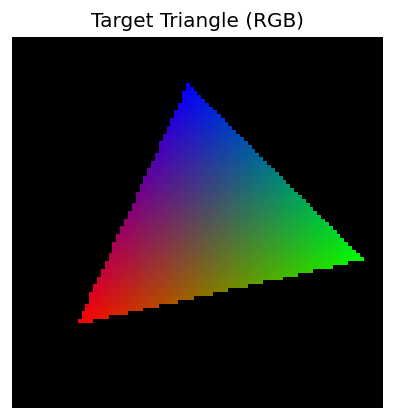

In [7]:
# Create target triangle
verts_target = torch.tensor([
    [-0.65, -0.55],
    [ 0.90, -0.20],
    [-0.05,  0.75],
], dtype=torch.float32)

colors_target = torch.tensor([
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0],  # Blue
], dtype=torch.float32)

img_target_tri = render_triangle_hard(H, W, verts_target, colors_target)
show_images([img_target_tri], ["Target Triangle (RGB)"])


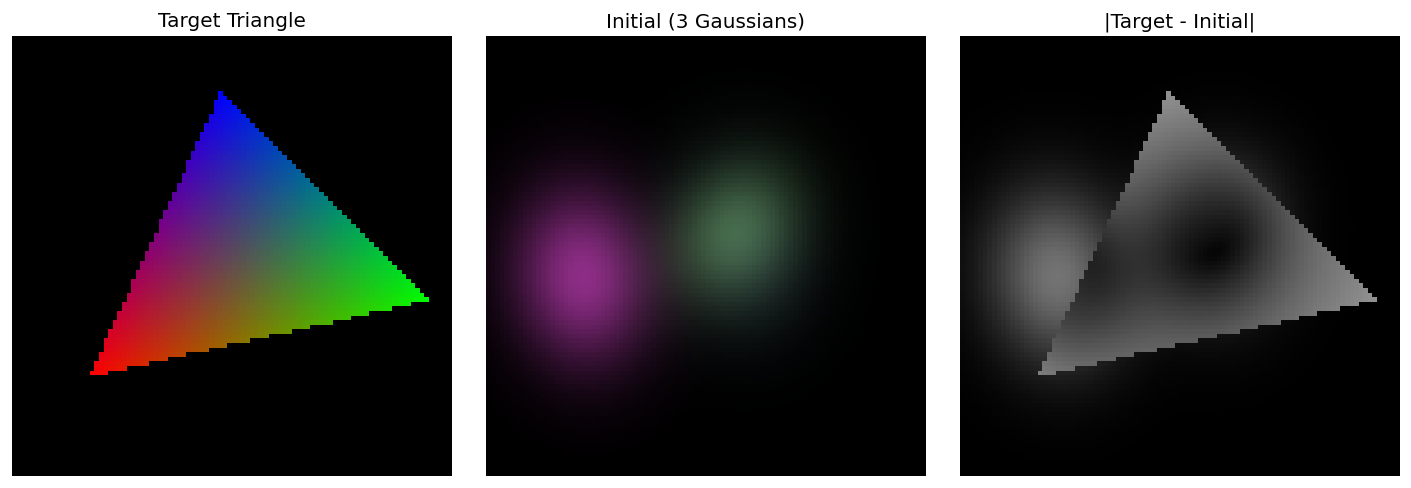

In [8]:
# Initialize multiple random Gaussians to fit the triangle
num_gaussians = 3  # Use multiple Gaussians to approximate the triangle

# Random initialization
torch.manual_seed(42)
init_mus = torch.randn(num_gaussians, 2) * 0.5
init_sigmas = torch.rand(num_gaussians, 2) * 0.2 + 0.1  # Random sizes
init_thetas = torch.rand(num_gaussians) * 2 * np.pi  # Random rotations [0, 2π]
init_opacities = torch.rand(num_gaussians) * 0.5 + 0.3  # Random opacities [0.3, 0.8]
init_rgbs = torch.rand(num_gaussians, 3) * 0.6 + 0.2  # Random RGB colors

img_init_tri = render_gaussians_2d(H, W, init_mus, init_sigmas, init_thetas, init_opacities, init_rgbs)
d_rgb_tri, d_mag_tri = diff_image(img_init_tri, img_target_tri)
show_images(
    [img_target_tri, img_init_tri, d_mag_tri],
    ["Target Triangle", f"Initial ({num_gaussians} Gaussians)", "|Target - Initial|"],
    figsize=(12, 4)
)

## Loss Function: L1 + D-SSIM

Following the original 3D Gaussian Splatting paper, we use a combination of **L1 loss** and **D-SSIM loss**:

$$\mathcal{L} = (1 - \lambda) \mathcal{L}_1 + \lambda \mathcal{L}_{\text{D-SSIM}}$$

where $\lambda = 0.2$ by default.

### Why combine L1 and SSIM?

**L1 Loss** (Mean Absolute Error):
- Measures pixel-wise color differences: $\mathcal{L}_1 = \frac{1}{N}\sum |I_{\text{pred}} - I_{\text{target}}|$
- Good for overall color accuracy
- Can miss perceptual quality (structure, texture)

**SSIM (Structural Similarity Index)**:
- Measures perceptual similarity by comparing luminance, contrast, and structure
- Better aligns with human visual perception
- Range: [-1, 1] where 1 = identical images
- Computed over local windows (11×11 by default)

**D-SSIM (Dissimilarity SSIM)**:
- Converts SSIM to a loss: $\mathcal{L}_{\text{D-SSIM}} = 1 - \text{SSIM}$
- Range: [0, 2] where 0 = perfect match
- Penalizes structural differences more than L1 alone

### Benefits of the Combined Loss

1. **L1 component**: Ensures accurate colors and prevents large errors
2. **D-SSIM component**: Preserves edges, textures, and structural details
3. **Together**: Produces sharper, more realistic results than MSE or L1 alone

This loss combination is a key factor in 3DGS achieving high-quality novel view synthesis!

In [9]:
import torch.nn.functional as F

def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)]))
        return gauss / gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    # Expects [H, W, C] images, converts to [1, C, H, W]
    if img1.ndim == 3:
        img1 = img1.permute(2, 0, 1).unsqueeze(0)
        img2 = img2.permute(2, 0, 1).unsqueeze(0)
    
    channel = img1.size(1)
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

In [10]:
# Optimize multiple Gaussians to fit the triangle - now with rotation and pruning!
mus_param = init_mus.clone().detach().requires_grad_(True)
sigmas_param = init_sigmas.clone().detach().requires_grad_(True)
thetas_param = init_thetas.clone().detach().requires_grad_(True)
opacities_param = init_opacities.clone().detach().requires_grad_(True)
rgbs_param = init_rgbs.clone().detach().requires_grad_(True)

optimizer_tri = torch.optim.Adam([mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param], lr=0.01)

# Learning rate scheduler: exponential decay
lr_decay_rate = 0.995  # Decay factor per iteration
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_tri, gamma=lr_decay_rate)

history_tri = []
history_lr = []  # Track learning rate
snapshots_tri = []
snapshot_schedule_tri = {0, 1, 2, 5, 10, 20, 40, 80, 120, 160, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000}

# Video frames
video_frames_tri = []
video_sample_rate = 1

# Snapshot initial state
snapshots_tri.append((0, mus_param.detach().clone(), sigmas_param.detach().clone(),
                     thetas_param.detach().clone(), opacities_param.detach().clone(), rgbs_param.detach().clone()))
video_frames_tri.append(img_init_tri.detach().cpu().numpy())

max_iters_tri = 1000
densify_interval = 30
prune_interval = 10  
max_sigma_threshold = 0.3 # Threshold for splitting (and avoiding cloning)
min_opacity_threshold = 0.05  # Minimum opacity to keep a Gaussian

for it in range(max_iters_tri):
    optimizer_tri.zero_grad()
    
    # Clamp parameters to valid ranges
    with torch.no_grad():
        mus_param.clamp_(-1.5, 1.5)
        sigmas_param.clamp_(0.01, 1.0)
        opacities_param.clamp_(0.0, 1.0)
        rgbs_param.clamp_(0.0, 1.0)
        # No clamping for thetas - let them rotate freely
    
    # Render all Gaussians and compute loss
    img = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param)
    
    # L1 + D-SSIM loss
    lambda_dssim = 0.2
    l1_loss = torch.abs(img - img_target_tri).mean()
    ssim_loss = 1.0 - ssim(img, img_target_tri)
    loss = (1.0 - lambda_dssim) * l1_loss + lambda_dssim * ssim_loss
    
    # Backward pass
    loss.backward()
    
    # Save gradients before optimizer step (for cloning decision)
    mus_grad = mus_param.grad.clone() if mus_param.grad is not None else None
    
    optimizer_tri.step()
    
    # Learning rate decay starts from iteration 300
    if it >= 300:
        scheduler.step()
    
    # Density control: Clone, Split, and Prune
    if (it + 1) % densify_interval == 0 or (it + 1) % prune_interval == 0:
        with torch.no_grad():
            # Densification: Clone and Split (only until iter 300)
            if (it + 1) % densify_interval == 0 and it < 300:
                prev_count = mus_param.shape[0]
                
                # 1. Clone high-gradient Gaussians (that are NOT large)
                clone_full = clone_gaussians_if_high_grad(
                    mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param,
                    mus_grad, grad_threshold=0.0002, max_sigma=max_sigma_threshold
                )
                
                # 2. Split large Gaussians
                split_full = split_gaussians_if_large(
                    clone_full[0], clone_full[1], clone_full[2], clone_full[3], clone_full[4], 
                    max_sigma=max_sigma_threshold
                )
                
                # 3. Extend the optimizer with new points
                mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param = extend_optimizer_with_new_points(
                    optimizer_tri,
                    (mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param),
                    split_full,
                    prev_count,
                )
                mus_param.requires_grad_(True)
                sigmas_param.requires_grad_(True)
                thetas_param.requires_grad_(True)
                opacities_param.requires_grad_(True)
                rgbs_param.requires_grad_(True)
            
            # Pruning: Remove low-opacity Gaussians (continues throughout all training)
            if (it + 1) % prune_interval == 0:
                prune_result = prune_gaussians(
                    mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param,
                    min_opacity=min_opacity_threshold, max_sigma=None
                )
                mus_pruned, sigmas_pruned, thetas_pruned, opacities_pruned, rgbs_pruned, keep_mask = prune_result
                
                # Only update if we actually pruned something
                if keep_mask.sum() < len(mus_param):
                    mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param = remove_from_optimizer(
                        optimizer_tri,
                        (mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param),
                        keep_mask
                    )
                    mus_param.requires_grad_(True)
                    sigmas_param.requires_grad_(True)
                    thetas_param.requires_grad_(True)
                    opacities_param.requires_grad_(True)
                    rgbs_param.requires_grad_(True)
    
    # Record history
    history_tri.append(loss.item())
    history_lr.append(scheduler.get_last_lr()[0])
    
    # Take snapshots
    if (it + 1) in snapshot_schedule_tri:
        snapshots_tri.append((it + 1, mus_param.detach().clone(), sigmas_param.detach().clone(),
                             thetas_param.detach().clone(), opacities_param.detach().clone(), rgbs_param.detach().clone()))
    
    # Capture video frames
    if (it + 1) % video_sample_rate == 0:
        frame = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param).detach().cpu().numpy()
        video_frames_tri.append(frame)
    
    if (it + 1) % 50 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Iteration {it+1}/{max_iters_tri}, Loss: {loss.item():.6f}, LR: {current_lr:.6f}, Gaussians: {mus_param.shape[0]}")

# Add final frame
final_frame = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param).detach().cpu().numpy()
video_frames_tri.append(final_frame)

print(f"Final loss: {history_tri[-1]:.6f}")
print(f"Final learning rate: {history_lr[-1]:.6f}")
print(f"Final number of Gaussians: {mus_param.shape[0]} (started with {num_gaussians})")

Cloning: 3 Gaussians → 3 new points added
Iteration 50/1000, Loss: 0.078751, LR: 0.010000, Gaussians: 6
Cloning: 6 Gaussians → 6 new points added
Cloning: 11 Gaussians → 11 new points added
Splitting: 1 Gaussians → 1 new points added
Iteration 100/1000, Loss: 0.044310, LR: 0.010000, Gaussians: 24
Cloning: 22 Gaussians → 22 new points added
Splitting: 2 Gaussians → 2 new points added
Cloning: 45 Gaussians → 45 new points added
Splitting: 1 Gaussians → 1 new points added
Iteration 150/1000, Loss: 0.015481, LR: 0.010000, Gaussians: 94
Pruning: 6 Gaussians removed (kept 88)
Cloning: 77 Gaussians → 77 new points added
Pruning: 1 Gaussians removed (kept 164)
Pruning: 6 Gaussians removed (kept 158)
Pruning: 9 Gaussians removed (kept 149)
Iteration 200/1000, Loss: 0.010443, LR: 0.010000, Gaussians: 149
Cloning: 114 Gaussians → 114 new points added
Pruning: 9 Gaussians removed (kept 254)
Pruning: 21 Gaussians removed (kept 233)
Pruning: 17 Gaussians removed (kept 216)
Cloning: 154 Gaussians → 1

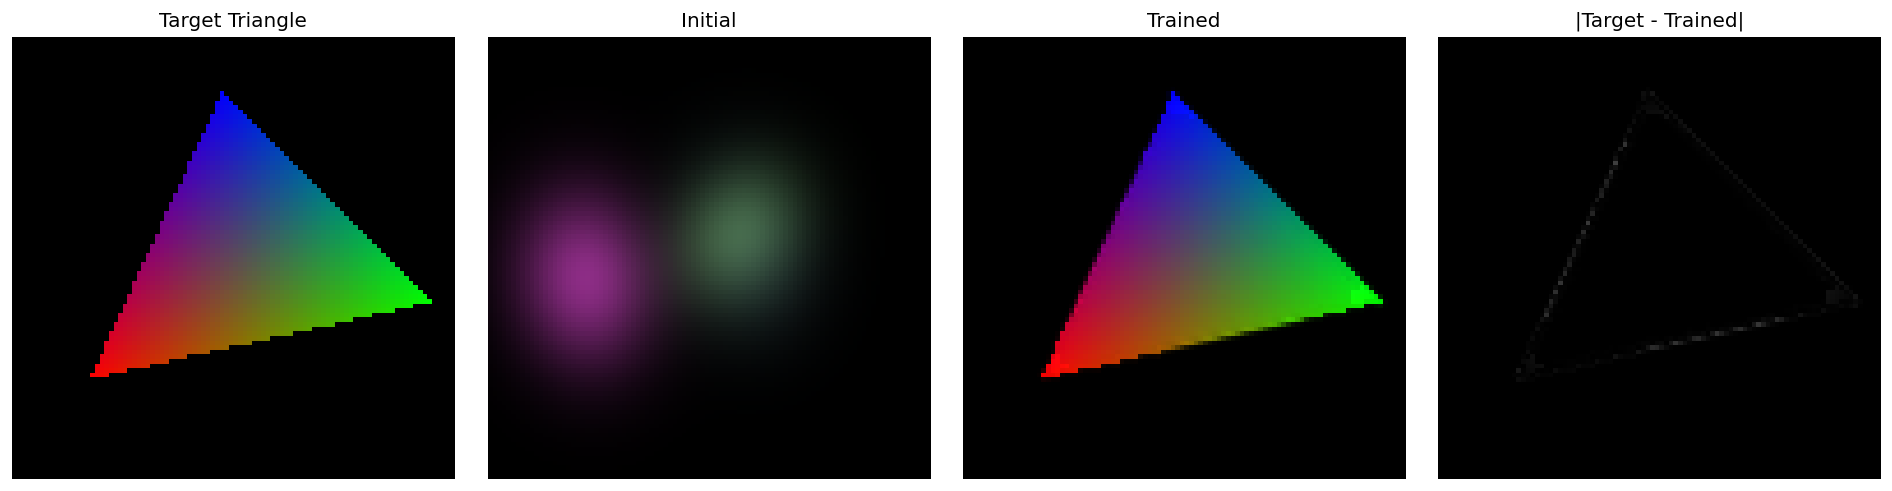

In [11]:
# Final result visualization
img_trained_tri = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param)
d_rgb_t, d_mag_t = diff_image(img_target_tri, img_trained_tri)

show_images(
    [img_target_tri, img_init_tri, img_trained_tri, d_mag_t],
    ["Target Triangle", "Initial", "Trained", "|Target - Trained|"],
    figsize=(16, 4)
)

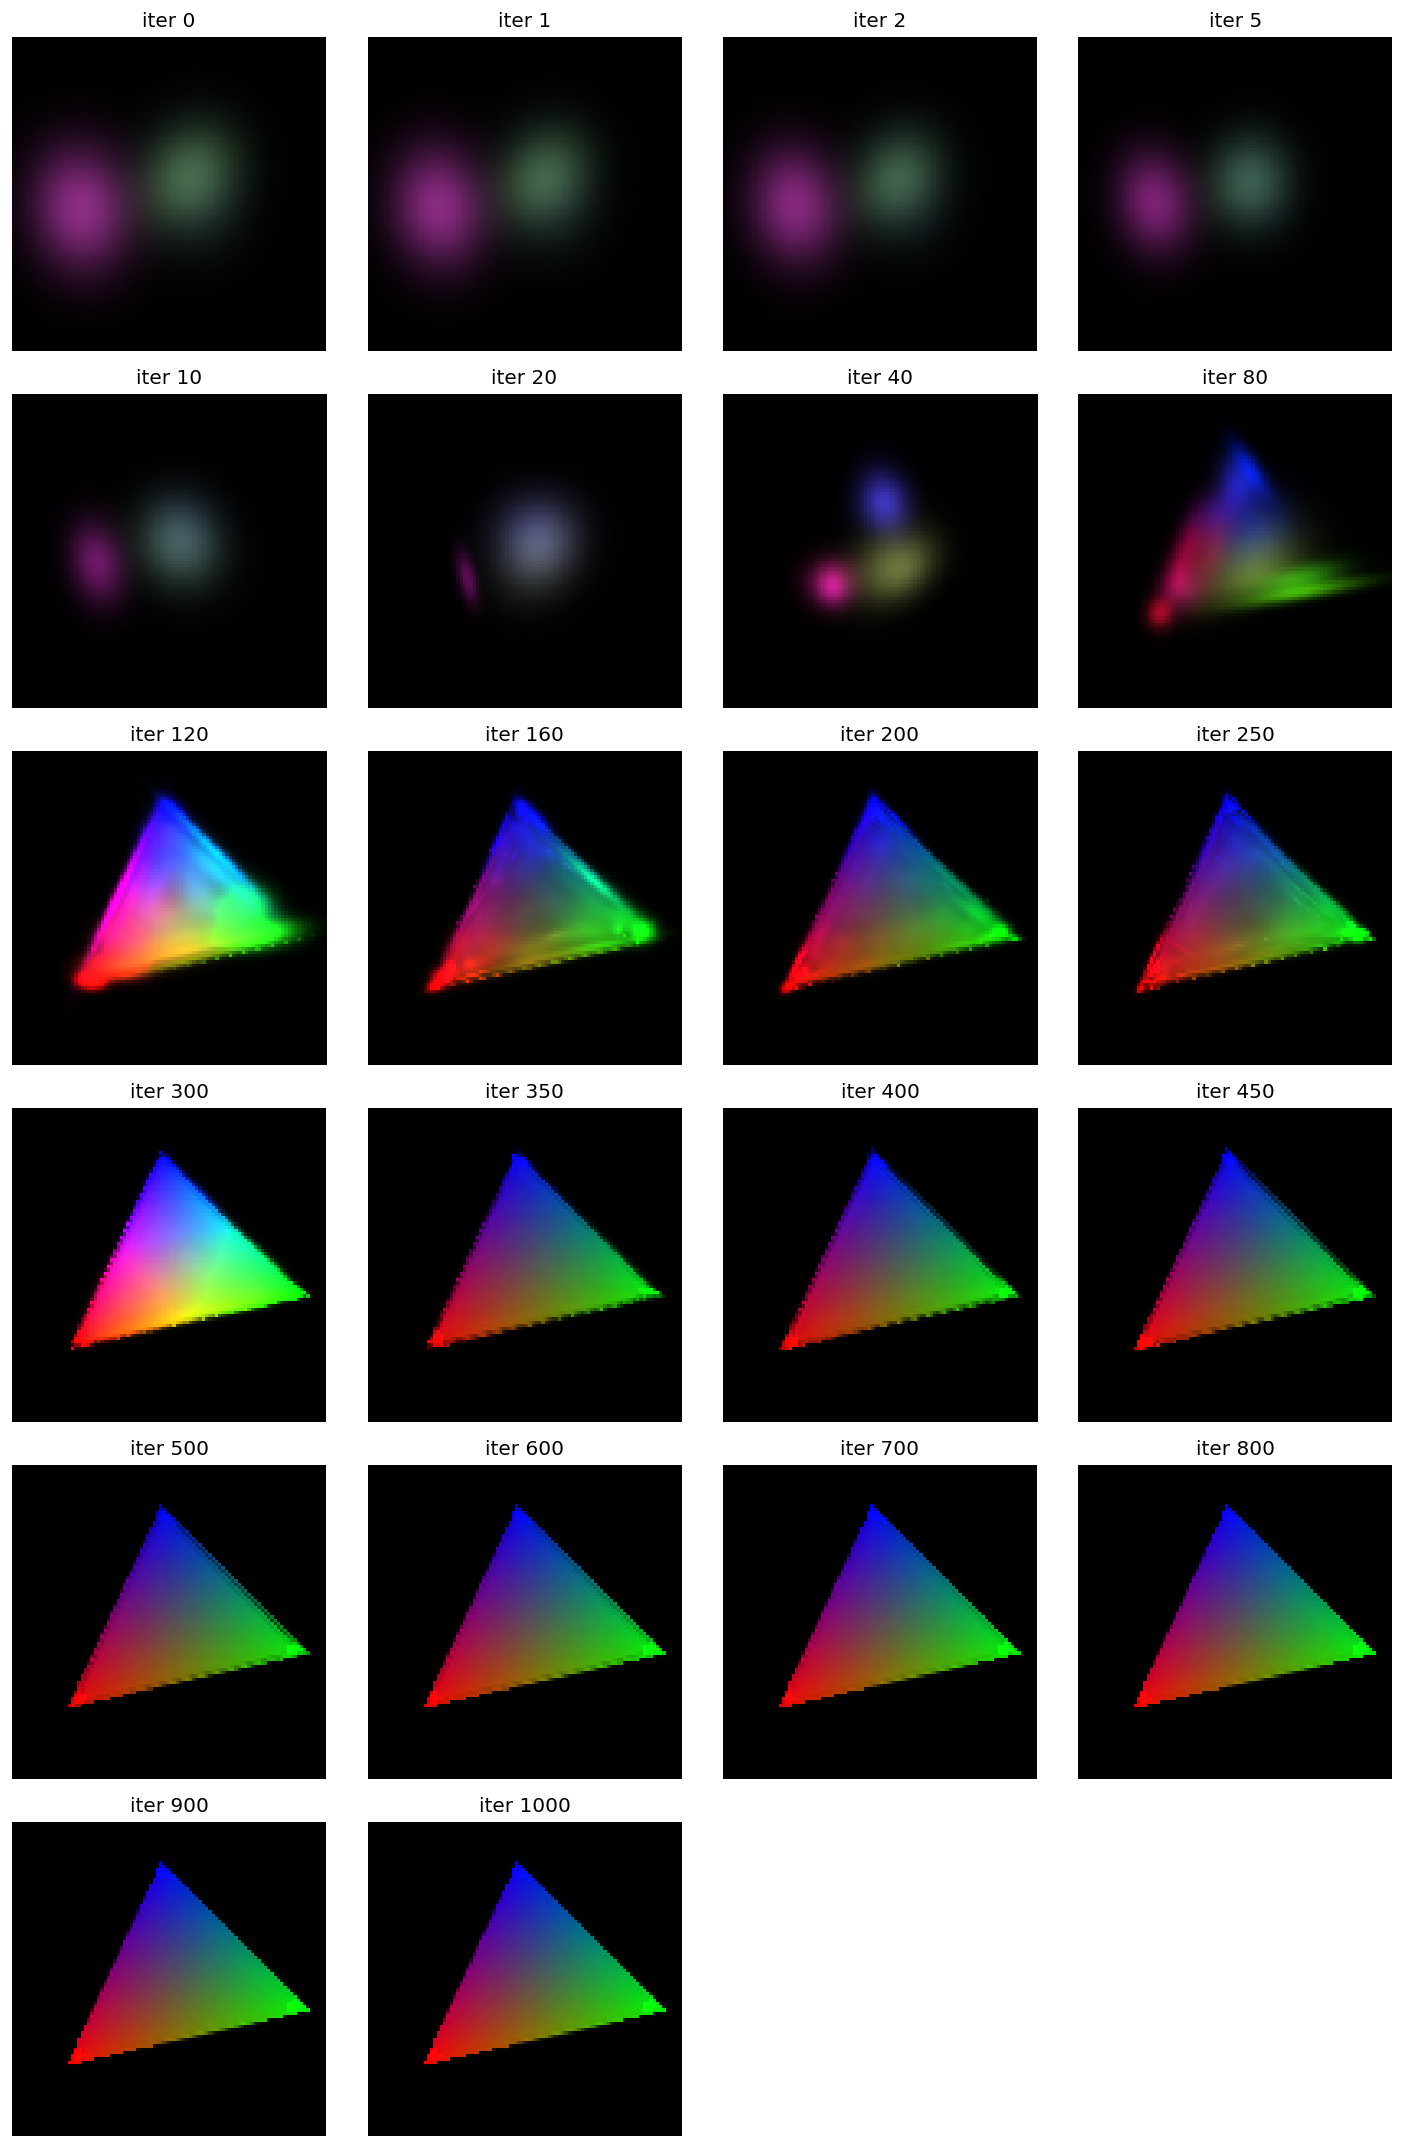

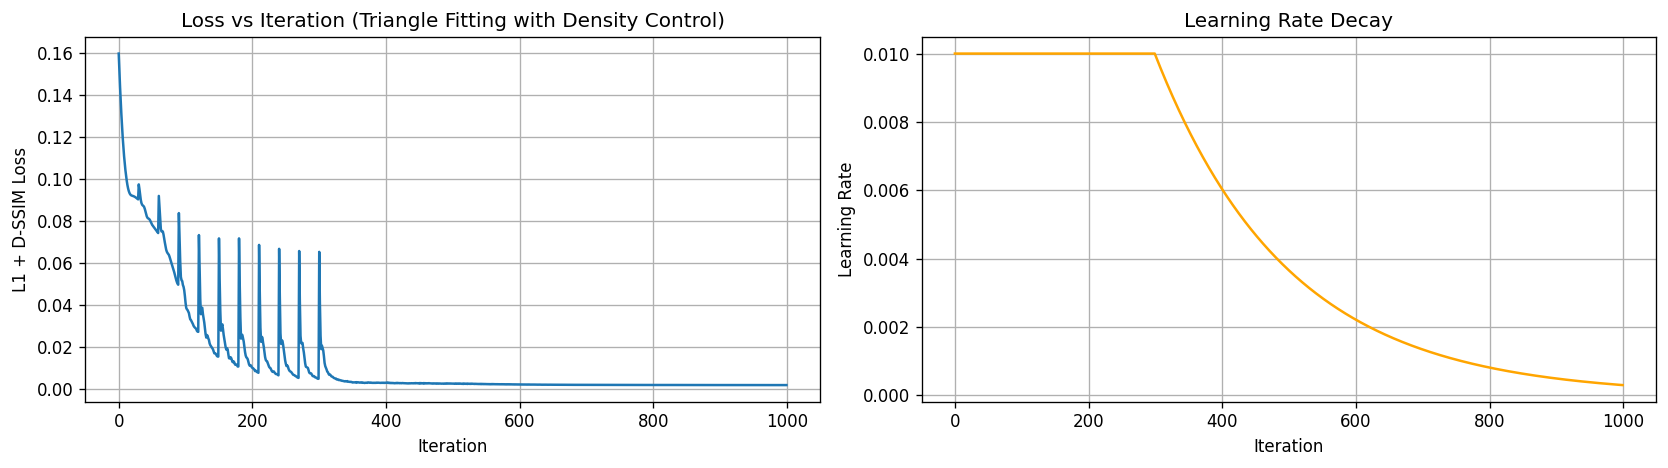

=== Optimization Results (Triangle Fitting with Rotation) ===
Number of Gaussians: 3
Initial loss: 0.159510
Final loss: 0.001946
Improvement: 98.78%
Initial LR: 0.010000, Final LR: 0.000299
Key insight: Rotated Gaussians can better approximate oriented features!
Full 2×2 covariance matrices allow alignment with triangle edges.


In [12]:
# Show training snapshots for triangle fitting
seen = set()
snapshots_tri_unique = []
for snapshot in snapshots_tri:
    it = snapshot[0]
    if it not in seen:
        snapshots_tri_unique.append(snapshot)
        seen.add(it)
snapshots_tri_unique.sort(key=lambda t: t[0])

snap_imgs = []
snap_titles = []
for snapshot in snapshots_tri_unique:
    it, mus, sigmas, thetas, opacities, rgbs = snapshot
    snap_imgs.append(render_gaussians_2d(H, W, mus, sigmas, thetas, opacities, rgbs))
    snap_titles.append(f"iter {it}")
show_image_grid(snap_imgs, snap_titles, cols=4, cell_size=3.0)

# Loss curve and learning rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(history_tri)
ax1.set_title(f"Loss vs Iteration (Triangle Fitting with Density Control)")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("L1 + D-SSIM Loss")
ax1.grid(True)

ax2.plot(history_lr, color='orange')
ax2.set_title("Learning Rate Decay")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Learning Rate")
ax2.grid(True)

plt.tight_layout()
plt.show()

print("=== Optimization Results (Triangle Fitting with Rotation) ===")
print(f"Number of Gaussians: {num_gaussians}")
print(f"Initial loss: {history_tri[0]:.6f}")
print(f"Final loss: {history_tri[-1]:.6f}")
print(f"Improvement: {(1 - history_tri[-1]/history_tri[0]) * 100:.2f}%")
print(f"Initial LR: {history_lr[0]:.6f}, Final LR: {history_lr[-1]:.6f}")

print("Key insight: Rotated Gaussians can better approximate oriented features!")
print("Full 2×2 covariance matrices allow alignment with triangle edges.")

In [13]:
# Save and display training video for triangle fitting
print(f"Creating video with {len(video_frames_tri)} frames...")
save_training_video(video_frames_tri, "gaussian_triangle_training.mp4", fps=30, 
                   title=f"Triangle Fitting with {num_gaussians} Gaussians")
Video("gaussian_triangle_training.mp4", embed=True, width=600)

Creating video with 1002 frames...
Video saved to gaussian_triangle_training.mp4


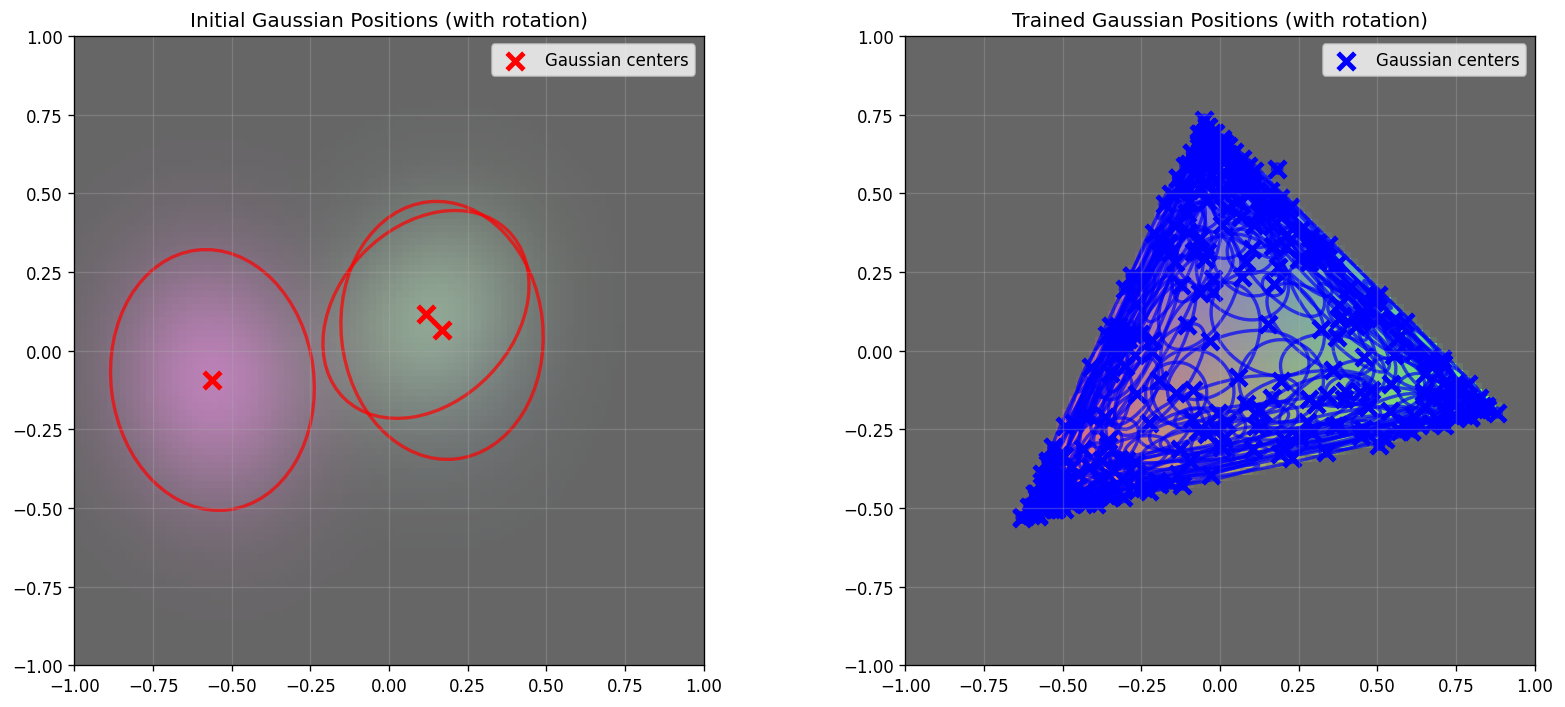

Notice how the Gaussians:
• Moved to concentrate around the triangle edges
• Adjusted their sizes to better cover the target shape
• Rotated to align with the triangle's oriented edges
• Changed colors to match the target RGB distribution


In [14]:
# Visualize Gaussian positions and their evolution with rotation
from matplotlib.patches import Ellipse

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Initial positions
mus_np = init_mus.detach().cpu().numpy()
ax1.imshow(img_init_tri.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', alpha=0.6)
ax1.scatter(mus_np[:, 0], mus_np[:, 1], c='red', s=100, marker='x', linewidths=3, label='Gaussian centers')
for i in range(num_gaussians):
    ellipse = Ellipse(
        (mus_np[i, 0], mus_np[i, 1]),
        width=init_sigmas[i, 0].item() * 3,
        height=init_sigmas[i, 1].item() * 3,
        angle=np.degrees(init_thetas[i].item()),  # Convert radians to degrees
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        alpha=0.7
    )
    ax1.add_patch(ellipse)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_aspect('equal')
ax1.set_title('Initial Gaussian Positions (with rotation)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final positions
mus_np = mus_param.detach().cpu().numpy()
ax2.imshow(img_trained_tri.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', alpha=0.6)
ax2.scatter(mus_np[:, 0], mus_np[:, 1], c='blue', s=100, marker='x', linewidths=3, label='Gaussian centers')
for i in range(len(mus_param)):  # draw ellipses for all current Gaussians after splits
    ellipse = Ellipse(
        (mus_np[i, 0], mus_np[i, 1]),
        width=sigmas_param[i, 0].item() * 3,
        height=sigmas_param[i, 1].item() * 3,
        angle=np.degrees(thetas_param[i].item()),  # Convert radians to degrees
        edgecolor='blue',
        facecolor='none',
        linewidth=2,
        alpha=0.7
    )
    ax2.add_patch(ellipse)
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_aspect('equal')
ax2.set_title('Trained Gaussian Positions (with rotation)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how the Gaussians:")
print("• Moved to concentrate around the triangle edges")
print("• Adjusted their sizes to better cover the target shape")
print("• Rotated to align with the triangle's oriented edges")
print("• Changed colors to match the target RGB distribution")

## 참고자료 (References)

**3D Gaussian Splatting for Real-Time Radiance Field Rendering (2023)**
- Kerbl et al., SIGGRAPH 2023
- [Paper](https://arxiv.org/abs/2308.04079) | [Project Page](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/)
- Introduced Gaussian splatting for 3D scene representation